In [1]:
import os
import io
import random
import fnmatch
from csv import DictWriter
import pandas as pd

import pdb

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from deap import base, creator, tools
import math

1 Name: Mavrovouniotis Menelaou Instances Test: 1 

2 COMMENT: Modificatification of E-n22-k4 instance. Modified by Mavrovouniotis Menelaou.

3 TYPE: EVRP 

4 OPTIMAL_VALUE: 384.678035 

5 VEHICLES: 4 

6 DIMENSION: 22 

7 STATIONS: 8 

8 CAPACITY: 6000 

9 ENERGY_CAPACITY: 94 

10 ENERGY_CONSUMPTION: 1.20 

11 EDGE_WEIGHT_FORMAT: EUC_2D

12 NODE_COORD_SECTION 

13 1 145 215 

14 2 151 264 

15 3 159 261 

16 4 130 254 

17 5 128 252 

18 6 163 247 

19 7 146 246 

20 8 161 242 

21 9 142 239 

22 10 163 236 

23 11 148 232 

24 12 128 231 

25 13 156 217 

26 14 129 214 

27 15 146 208 

28 16 164 208 

29 17 141 206 

30 18 147 193 

31 19 164 193 

32 20 129 189 

33 21 155 185 

34 22 139 182 

35 23 137 193 

36 24 137 213 

37 25 137 234 

38 26 137 254 

39 27 155 193 

40 28 155 213 

41 29 155 234 

42 30 155 254 

43 DEMAND_SECTION 

44 1 0

45 2 1100

46 3 700

47 4 800

48 5 1400

49 6 2100

50 7 400

51 8 800

52 9 100

53 10 500

54 11 600

55 12 1200

56 13 1300

57 14 1

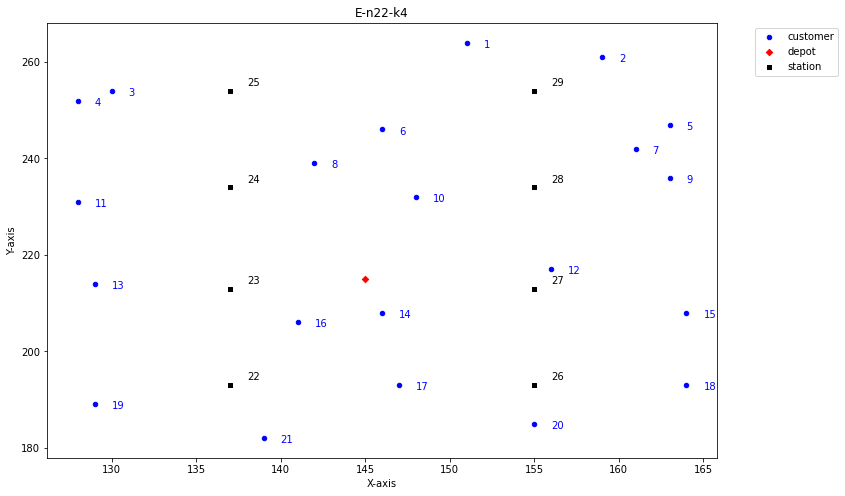

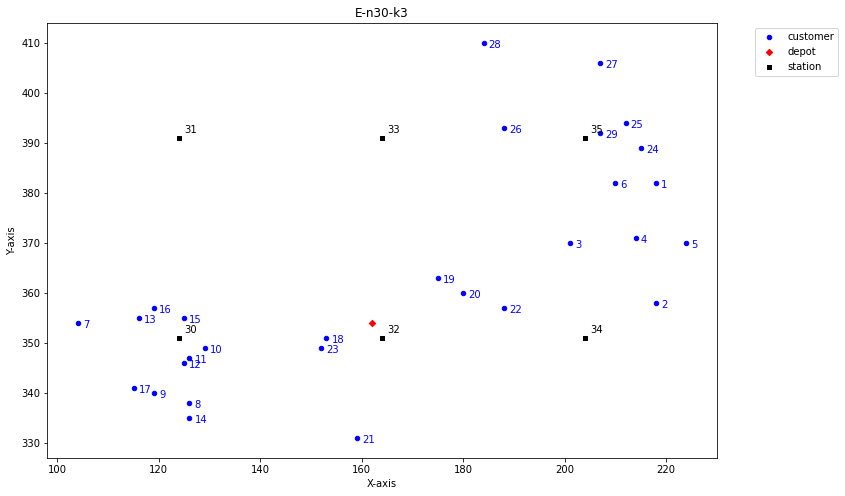

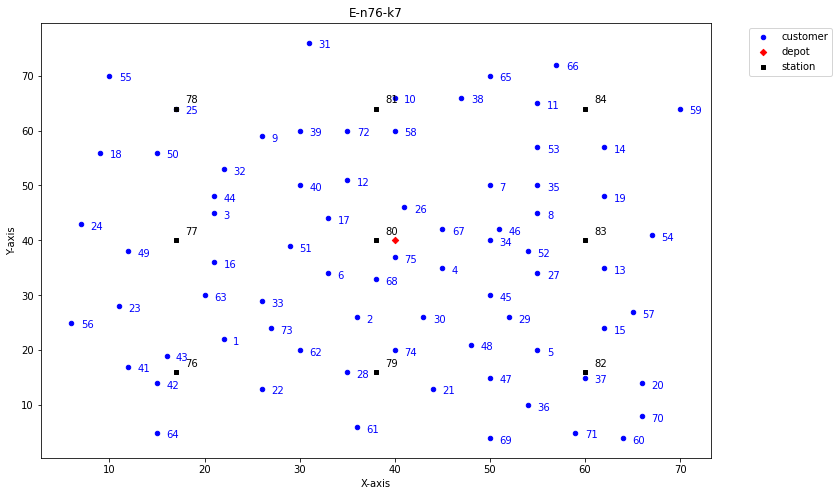

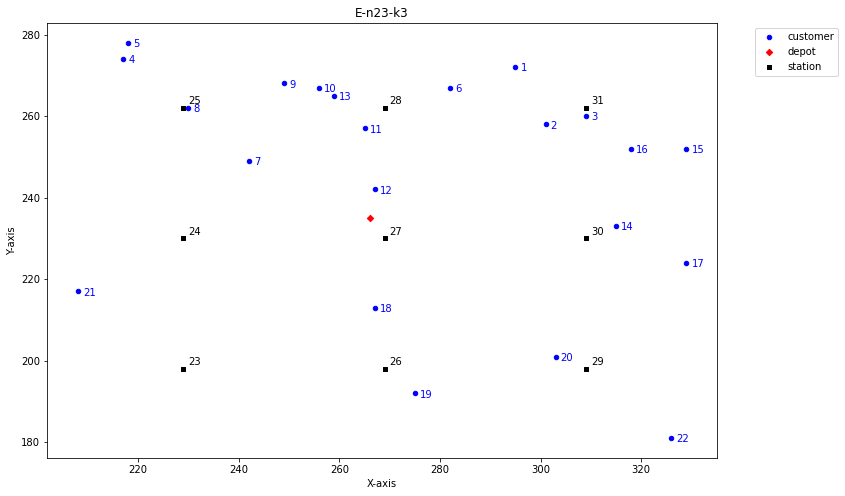

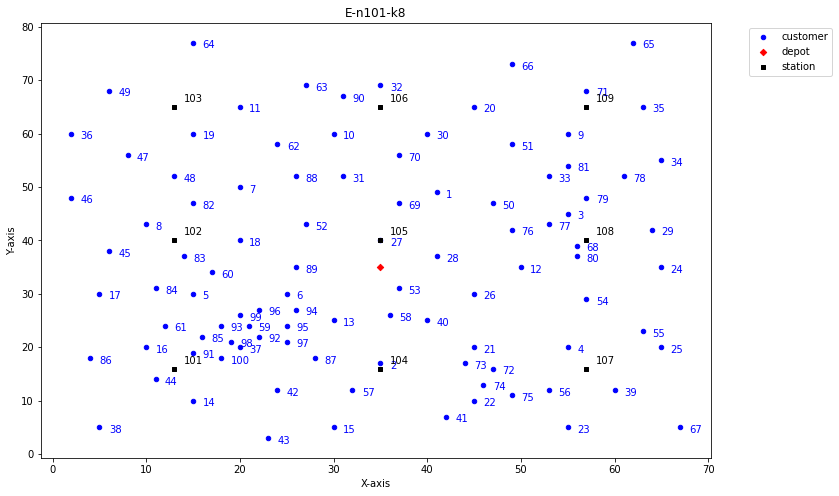

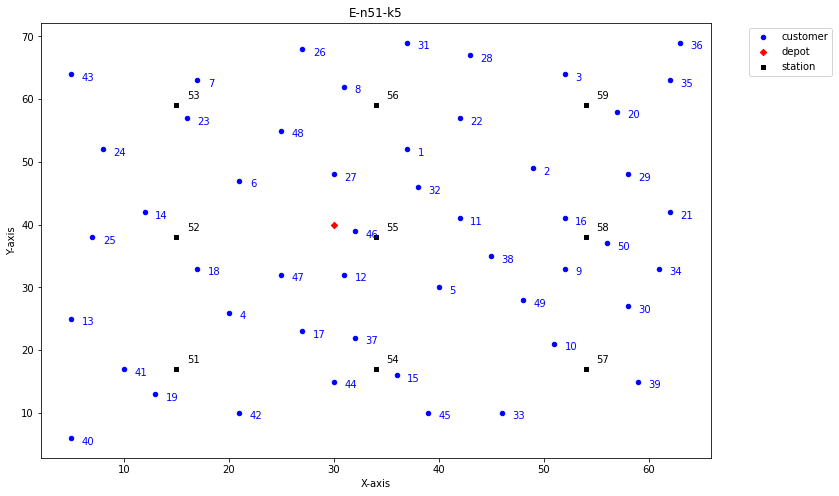

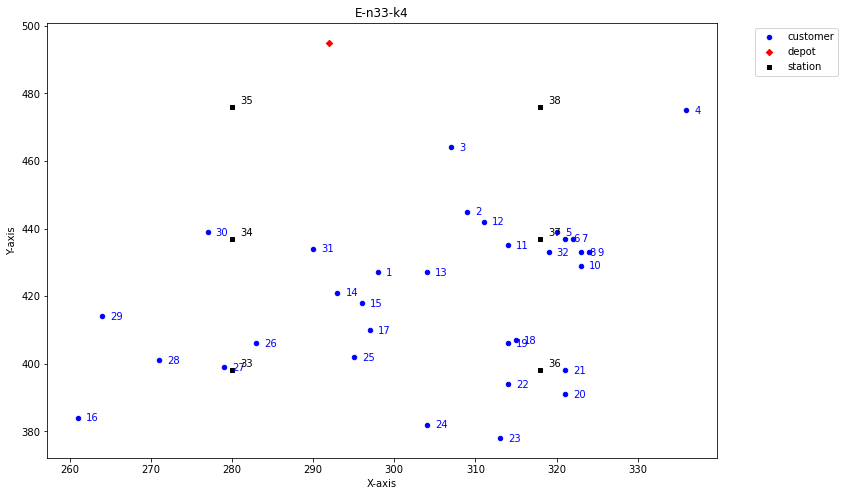

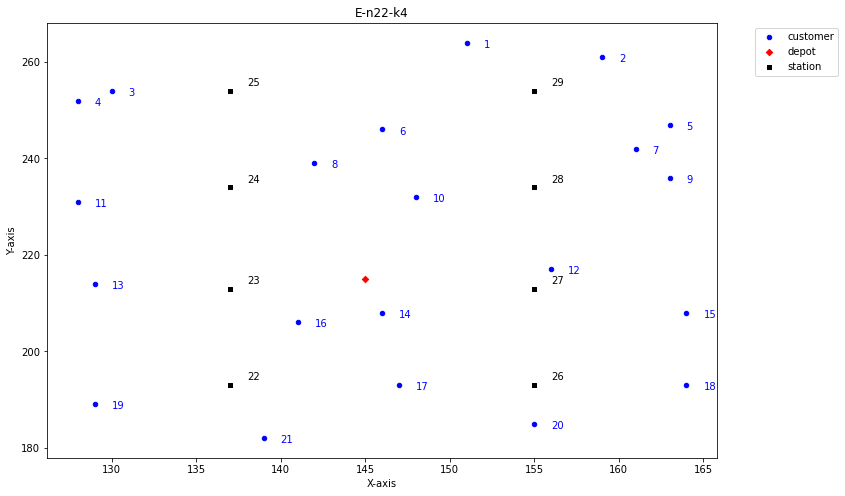

In [304]:
%run read_data.ipynb > /dev/null

In [3]:
BASE_DIR = os.path.abspath(os.path.dirname(os.path.dirname('.')))
data_dir = os.path.join(BASE_DIR, 'evrp-benchmark-set')
result_dir = os.path.join(BASE_DIR, 'results')

In [134]:
# instance.__dict__

## Utils

In [305]:
def is_capacity_feasible(individual, capacity, demands):
    """Check if a given individual is feasible with respect to vehicle capacity.
    
    Args:
        individual: A list of lists, where each sublist represents a vehicle and its assigned customers.
        capacity: The capacity of the vehicles.
        demands: The dictionary containing the demands of each customer.
        
    Returns:
        bool: True if the individual is feasible, False otherwise.
    """
    
    # Iterate through each route in the individual
    for route in individual:
        # Calculate the total demand of the customers in the route
        total_demand = sum(demands[f'{customer}'] for customer in route)
        
        # If the total demand exceeds the vehicle's capacity, the individual is not feasible
        if total_demand > capacity:
            return False
    
    # If none of the routes exceed the vehicle's capacity, the individual is feasible
    return True

def reconstruct_individual(flat_ind, route_lengths):
    '''Reconstruct the original format of an individual from a flattened version.
    
    Args:
        flat_ind: A flattened version of an individual, where all routes are combined into a single list.
        route_lengths: A list of integers representing the length of each route in the original individual format.

    Returns:
        A list of lists, where each sublist represents a vehicle and its assigned customers.
    '''
    individual = []
    start_idx = 0
    for length in route_lengths:
        individual.append(flat_ind[start_idx:start_idx + length])
        start_idx += length
    return individual


def deduplicate_population(population):
    """
    Remove duplicate individuals from a population.
    
    Args:
        population: A list of individuals.
        
    Returns:
        A deduplicated population as a list.
    """
    deduplicated_population = []

    for individual in population:
        if individual not in deduplicated_population:
            deduplicated_population.append(individual)

    return deduplicated_population

def plot_route(route, df, ax, route_color='green', linewidth=1):
    # Add the depot index (0) at the beginning and end of the route
    route_with_depot = [0] + route + [0]

    for i in range(len(route_with_depot) - 1):
        start_customer_idx = route_with_depot[i]
        end_customer_idx = route_with_depot[i + 1]

        x1, y1 = df['x_pos'].loc[start_customer_idx], df['y_pos'].loc[start_customer_idx]
        x2, y2 = df['x_pos'].loc[end_customer_idx], df['y_pos'].loc[end_customer_idx]

        ax.plot([x1, x2], [y1, y2], color=route_color, linewidth=linewidth)

def visualize_routes(routes, df, title='Route Plot'):
    colors = {'depot': 'red', 'customer': 'blue', 'station': 'black'}
    markers = {'depot': 'D', 'customer': 'o', 'station': 's'}

    fig, ax = plt.subplots(figsize=(12, 8))
    for label, group in df.groupby('label'):
        if label == 'depot':
            group.plot(kind='scatter', x='x_pos', y='y_pos', label=label, color=colors[label], marker=markers[label], ax=ax, s=30)
        elif label == 'customer':
            group.plot(kind='scatter', x='x_pos', y='y_pos', label=label, color=colors[label], marker=markers[label], ax=ax)
        else:  # For the 'station' label
            group.plot(kind='scatter', x='x_pos', y='y_pos', label=label, color=colors[label], marker=markers[label], ax=ax, s=30) 
            

        # Add node_no labels for customer nodes
        if label == 'customer':
            for index, row in group.iterrows():
                ax.text(row['x_pos'] + 1, row['y_pos'] - 1, str(row['node_no']), fontsize=10, color=colors[label])
        elif label == 'station':
            for index, row in group.iterrows():
                ax.text(row['x_pos'] + 1, row['y_pos'] + 1, str(row['node_no']), fontsize=10, color=colors[label])
    
    # Create a colormap and generate a list of colors for each route
    colormap = plt.cm.get_cmap('tab10', len(routes))
    colors = [mcolors.rgb2hex(colormap(i)[:3]) for i in range(len(routes))]

    for i, route in enumerate(routes):
        plot_route(route, df, ax, route_color=colors[i])
    
    
    ax.set_title(title)
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')

    # Move the legend and show the plot inside the loop
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

## GA Implementation
-----
### Individual (Chromosome) encoding
* `0 - 5 - 6 - 8 - 0 - 1 - 2 - 3 - 4 - 0 - 7 - 0`
* there are many methods to generate the individual, for example, Density-Based Clustering Algorithm to partition the set in advance

### Individual initialization

1. generate individual without capacity violation
    * evenly
    * randomly
    * approach proposed by David & Viktor (manuscript)
2. make the individual feasible w.r.t energy consumption, otherwise discard these infeasible individuals. 
we can use Relaxed ZGA repair procedure.



In [47]:
def generate_individual_evenly(num_vehicles, num_customers):
    """Generate an individual by distributing customers evenly across vehicles.
    
    Args:
        num_vehicles: The number of vehicles.
        num_customers: The number of customers.
        
    Returns:
        A list of lists, where each sublist represents a vehicle and its assigned customers.
    """

    # Create a list of customer numbers and shuffle it
    customers = list(range(1, num_customers + 1))

    # Initialize the individual
    individual = []

    random.shuffle(customers)
    individual = [customers[i::num_vehicles] for i in range(num_vehicles)]
    
    return individual


def generate_individual_randomly(num_vehicles, num_customers):
    """Generate an individual by randomly assigning customers to vehicles.
    
    Args:
        num_vehicles: The number of vehicles.
        num_customers: The number of customers.
        
    Returns:
        A list of lists, where each sublist represents a vehicle and its assigned customers.
    """
    
    # Initialize an empty individual with a list for each vehicle
    individual = [[] for _ in range(num_vehicles)]
    
    # Create a list of customers and shuffle it
    customers = list(range(1, num_customers + 1))
    random.shuffle(customers)
    
    for customer in customers:
        # Assign the customer to a random vehicle
        vehicle = random.randint(0, num_vehicles - 1)
        individual[vehicle].append(customer)
    
    return individual


In [137]:
num_vehicles =  instance.num_of_vehicles
num_customers = instance.dimension - 1
capacity = instance.capacity
demands = instance.demands


pop_size = 10000
pop_1 = []
pop_2 = []
for x in range(pop_size):
    ind1 = generate_individual_evenly(num_vehicles, num_customers)
    pop_1.append(ind1)
    ind2 = generate_individual_randomly(num_vehicles, num_customers)
    pop_2.append(ind2)

num_cap_fea_1 = 0
num_cap_fea_2 = 0

for ind in pop_1:
    cap_fea = is_capacity_feasible(ind, capacity, demands)
#     print(f'{ind}  {cap_fea}')
    if cap_fea:
        num_cap_fea_1 += 1
    
for ind in pop_2:
    cap_fea = is_capacity_feasible(ind, capacity, demands)
#     print(f'{ind}  {cap_fea}')
    if cap_fea:
        num_cap_fea_2 += 1
        
print('-------------', end="\n\n")
print('The number of capacity feasible individual for population 1: ', num_cap_fea_1/pop_size)
print('The number of capacity feasible individual for population 2: ', num_cap_fea_2/pop_size)

-------------

The number of capacity feasible individual for population 1:  0.025
The number of capacity feasible individual for population 2:  0.0047


## Operators (Moves)

* Crossover - partially matched crossover (PMX)

* muatation

* 2-opt-route  <br>
  For each plain route, make the 2-opt operator to ensure that there are no intersecting paths in the route, i.e., find the route has the shortest the total length.
  
* a

In [185]:
# crossover
def cx_partially_matched(ind1, ind2):
    """Partially Matched Crossover (PMX)
    
    Args:
        ind1: The first individual participating in the crossover.
        ind2: The second individual participating in the crossover.
        
    Returns:
        A tuple of two individuals.
    """
    
    route_lengths_1 = [len(route) for route in ind1]
    route_lengths_2 = [len(route) for route in ind2]
    flat_ind1 = [node - 1 for route in ind1 for node in route]
    flat_ind2 = [node - 1 for route in ind2 for node in route]
    
    size = min(len(flat_ind1), len(flat_ind2))
    pos1, pos2 = [0] * size, [0] * size

    # Initialize the position of each index in the individuals
    for i in range(size):
        pos1[flat_ind1[i]] = i
        pos2[flat_ind2[i]] = i
    
    # Choose crossover points
    cxpoint1 = random.randint(0, size)
    cxpoint2 = random.randint(0, size - 1)
    if cxpoint2 >= cxpoint1:
        cxpoint2 += 1
    else:  # Swap the two cx points
        cxpoint1, cxpoint2 = cxpoint2, cxpoint1

    # Apply crossover between cx points
    for i in range(cxpoint1, cxpoint2):
        # Keep track of the selected values
        temp1 = flat_ind1[i]
        temp2 = flat_ind2[i]
        # Swap the matched value
        flat_ind1[i], flat_ind1[pos1[temp2]] = temp2, temp1
        flat_ind2[i], flat_ind2[pos2[temp1]] = temp1, temp2
        # Position bookkeeping
        pos1[temp1], pos1[temp2] = pos1[temp2], pos1[temp1]
        pos2[temp1], pos2[temp2] = pos2[temp2], pos2[temp1]

    # Increment node values back to original range
    flat_ind1 = [node + 1 for node in flat_ind1]
    flat_ind2 = [node + 1 for node in flat_ind2]
    

    ind1_reconstructed = reconstruct_individual(flat_ind1, route_lengths_1)
    ind2_reconstructed = reconstruct_individual(flat_ind2, route_lengths_2)
    
    return ind1_reconstructed, ind2_reconstructed


In [186]:
ind1 = [[11, 15, 17, 6], [1, 20, 12, 21, 5, 4], [3, 14, 7, 13, 10, 19, 2, 9], [18, 8, 16]] 
ind2 = [[15, 13, 17, 3, 18, 21, 9], [ 6, 20, 14], [19, 8, 11, 1, 2, 5, 16, 10, 12], [7, 4]]
a, b = cx_partialy_matched(ind1, ind2)
print(a)
print(b)

[[7, 15, 17, 20], [13, 5, 1, 3, 6, 14], [19, 8, 4, 18, 12, 21, 16, 2], [9, 11, 10]]
[[15, 18, 17, 19, 9, 3, 2], [20, 5, 8], [21, 11, 7, 13, 16, 6, 10, 12, 1], [4, 14]]


* __mutation__ 

In [202]:
# mutation
def mut_shuffle_indexes(individual, indpb):
    """Shuffle the attributes of the input individual and return the mutant.
    The *indpb* argument is the probability of each attribute to be moved. 

    Args:
        individual: Individual to be mutated.
        indpb: Independent probability for each attribute to be exchanged to
                  another position.
        
    Returns:
        A tuple of one individual.
    """
    route_lengths = [len(route) for route in individual]
    flat_ind = [node for route in individual for node in route]
    
    size = len(flat_ind)
    for i in range(size):
        if random.random() < indpb:
            swap_indx = random.randint(0, size - 2)
            if swap_indx >= i:
                swap_indx += 1
            flat_ind[i], flat_ind[swap_indx] = flat_ind[swap_indx], flat_ind[i]

    individual = reconstruct_individual(flat_ind, route_lengths)
    return individual,

In [267]:
ind1 = [[11, 15, 17, 6, 1, 20], [12, 21, 5, 4], [3, 14, 7, 13, 10, 19, 2, 9], [18, 8, 16]] 
_ind, = mut_shuffle_indexes(ind1, 0.2)
print(_ind)

[[14, 12, 17, 6, 1, 20], [15, 21, 4, 5], [3, 7, 11, 2, 10, 19, 13, 9], [18, 8, 16]]


In [281]:

candidates = []

num_vehicles =  instance.num_of_vehicles
num_customers = instance.dimension - 1
capacity = instance.capacity
demands = instance.demands

pop_size = 10000

pop = []
for x in range(pop_size):
    ind = generate_individual_randomly(num_vehicles, num_customers)
    pop.append(ind)

offspring = []
for ind1, ind2 in zip(pop[::2], pop[1::2]):
    child1, child2 = cx_partialy_matched(ind1, ind2)
    offspring.append(child1)
    offspring.append(child2)

num_cap_fea = 0
for ind in pop:
    cap_fea = is_capacity_feasible(ind, capacity, demands)
    if cap_fea:
        num_cap_fea += 1
        candidates.append(ind)
print('------------------ crossover -------------------')

print('The probability of capacity feasible individual for population: ', num_cap_fea/pop_size)


num_cap_fea = 0
for ind in offspring:
    cap_fea = is_capacity_feasible(ind, capacity, demands)
    if cap_fea:
        num_cap_fea += 1
        candidates.append(ind)

print('The probability of capacity feasible individual for offspring: ', num_cap_fea/pop_size)

print()
print('------------------ muatation -------------------')
mut_prob = 0.5
offspring_after_muatation = []
for ind in offspring:
    if random.random() < mut_prob:
        mutant, = mut_shuffle_indexes(ind, 0.2)
        offspring_after_muatation.append(mutant)

num_cap_fea = 0
for ind in offspring_after_muatation:
    cap_fea = is_capacity_feasible(ind, capacity, demands)
    if cap_fea:
        num_cap_fea += 1
        candidates.append(ind)

print('The probability of capacity feasible individual for offspring_after_muatation: ', num_cap_fea/pop_size)

print()
print('------------------ CANDIDATES -------------------')

CANDIDATES = deduplicate_population(candidates)


# for individual in CANDIDATES:
#     print(individual)
    
print(len(CANDIDATES))

------------------ crossover -------------------
The probability of capacity feasible individual for population:  0.0034
The probability of capacity feasible individual for offspring:  0.0035

------------------ muatation -------------------
The probability of capacity feasible individual for offspring_after_muatation:  0.0029

------------------ CANDIDATES -------------------
98


* __2-opt-route__

> 1. Croes GA. A method for solving traveling-salesman problems. Operations research. 1958 Dec;6(6):791-812.
> 2. Flood MM. The traveling-salesman problem. Operations research. 1956 Feb;4(1):61-75.

In [330]:
def two_opt(route, distance_matrix):
    """
    Perform 2-opt local search on a given route to optimize it.
    
    Args:
        route: A list of integers representing the customers in the route.
        distance_matrix: A 2D list or numpy array containing the distances between nodes.
    
    Returns:
        A list of integers representing the optimized route.
    """
    improved = True
    while improved:
        improved = False
        for i in range(1, len(route) - 2):
            for j in range(i + 1, len(route) - 1):
                
                # Calculate the cost difference between the old route and the new route obtained by swapping edges
                old_cost = distance_matrix[route[i - 1]][route[i]] + distance_matrix[route[j]][route[j + 1]]
                new_cost = distance_matrix[route[i - 1]][route[j]] + distance_matrix[route[i]][route[j + 1]]
                if new_cost < old_cost:
                    route[i:j + 1] = reversed(route[i:j + 1])
                    improved = True
    return route

[[20, 4, 16, 8, 6], [14, 18, 2, 9, 1, 17, 3], [12, 5, 7, 13], [21, 15, 10, 11, 19]]


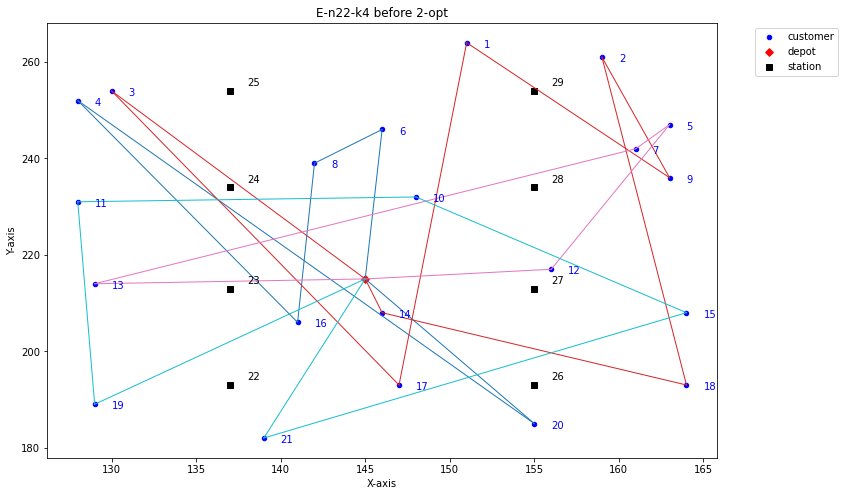

[[20, 16, 4, 6, 8], [14, 17, 18, 9, 2, 1, 3], [12, 7, 5, 13], [11, 10, 15, 21, 19]]


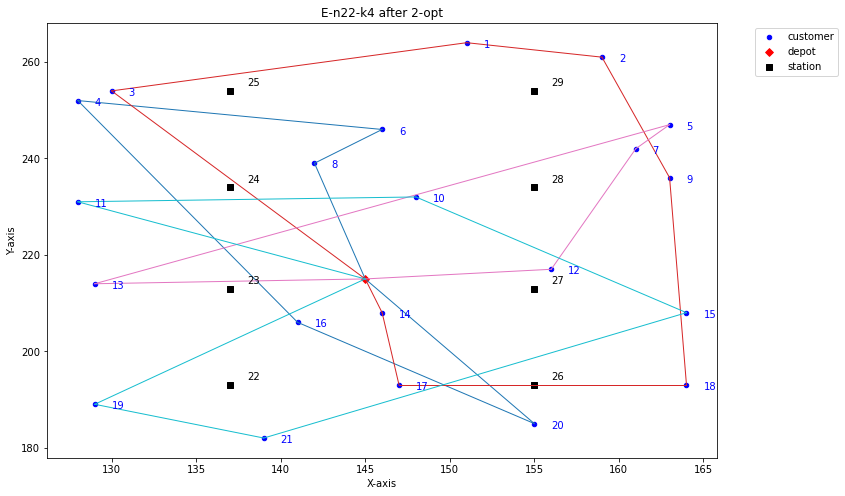

In [334]:
distance_matrix = instance.distance_matrix
df = create_dataframe(instance)

original_individual = CANDIDATES[1].copy()
print(original_individual)
visualize_routes(original_individual, df, instance.name + ' before 2-opt')

optimized_individual = []
for route in original_individual:
    extended_route = [0] + route + [0]
    improved_route = two_opt(extended_route, distance_matrix)
    optimized_individual.append(improved_route[1:-1])

print(optimized_individual)
visualize_routes(optimized_individual, df, instance.name + ' after 2-opt')
